In [66]:
'''
1. 데이터 수집 및 정제
2. 그래프 분석(히스토그램)
3. 기술통계 (요약 통계: 평균, 표준편차, 사분위  빈도분석: 빈도, 최빈값)
4. 추론통계 : 가설검정
5. 다변량 통계 : 상관/인과관계 분석 : 선형 회귀, 로지스틱 회귀
               비지도 분류 : 주성분, 군집분석
               -> 분류결과는 목표변수와 연계 분석
6. 기계학습 : 트리기반 -> 의사결정트리, 랜덤포레스트, 부스팅
            확률기반 -> KNN , Naive Bayesian, 신경망 등
7. 모델 평가
본 종합실습의 목적은 데이터를 수집하여 다양한 분석을 통해 불량 발생의 근본적인 원인을 찾고 개선을 위한 최적의 조건을 도출하고자 하는 것이다.
따라서 먼저 1.데이터 수집 및 정제를 통하여 데이터의 전처리를 진행하였고, 2.그래프 분석을 통한 탐색적 분석과 상관계수를 통하여 다중공선성과
해당 변수에 대한 특성을 파악하였다. 그 후에 3.로지스틱 회귀분석을 통하여 최종적으로 SCALE이라는 목적변수에 직접적으로 영향을 주는 유의미한
변수들을 추출하였다. 4.유의하다고 정의한 추출데이터를 바탕으로 여러 분류모델을 적용하여 어떠한 모델이 가장 우수한 성능으로 조건을 찾아내는지
확인하는 과정을 거쳤다.
'''
#한글폰트
import matplotlib.font_manager as fm

#행렬처리 모듈
import numpy as np
#자료구조인 Series, DataFrame 등을 제공하는 모듈
import pandas as pd
#추세 그래프 및 통계용 차트를 제공하는 시각화 모듈
import seaborn as sns
#그래프 및 시각화 모듈
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from sklearn import linear_model
from sklearn.preprocessing import scale, robust_scale, minmax_scale
#다중공선성 패키지 불러오기
from statsmodels.stats.outliers_influence import variance_inflation_factor
#sklearn 선형회귀 모형 -> 변수 선택법을 위함
from sklearn.linear_model import LinearRegression
#변수 선택법(후진제거법)log_model = sm.Logit.from_formula("""SCALE ~  PT_THK + PT_WDTH + PT_LTH + PT_WGT + C(FUR_NO) + FUR_HZ_TEMP + FUR_HZ_TIME + FUR_SZ_TEMP + FUR_SZ_TIME + FUR_TIME + FUR_EXTEMP + ROLLING_TEMP_T5 + C(HSB) + ROLLING_DESCALING+ C(WORK_GR) + 1""", ds_posco)
import os
from sklearn.feature_selection import RFE
#sklearn.tree 의 DecisionTreeClassifier : 분류의사결정나무
from sklearn.tree import DecisionTreeClassifier
#random forest
from sklearn.ensemble import RandomForestClassifier
#GB
from sklearn.ensemble import GradientBoostingClassifier
#SVM
from sklearn.svm import SVC
#F1 Score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
#데이터 표준화 함수
from sklearn.preprocessing import StandardScaler

for f in fm.fontManager.ttflist:
    if 'NanumBarunGothic' in f.fname: plt.rcParams['font.family']='NanumBarunGothic'
    # 폰트 나눔고딕으로

print(plt.rcParams['font.family'])

matplotlib.rcParams['axes.unicode_minus'] = False # '-'기호 제대로 나오게

['NanumBarunGothic']


In [67]:
ds_posco = pd.read_csv("../../실습화일/SCALE불량.csv", encoding='euc-kr', engine='python')
ds_posco

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1133,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1135,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1121,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1127,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1128,873,적용,8,1조
5,PB562779,2008-08-01:00:02:06,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1143,127,1128,57,314,1128,874,적용,8,4조
6,PB562780,2008-08-01:00:02:28,양품,BV-EH36-TM,T8,38.33,3099,16719,15590,1호기,...,1138,126,1130,50,289,1130,878,적용,8,2조
7,PB562781,2008-08-01:00:02:21,양품,BV-EH36-TM,T8,38.33,3099,16719,15590,1호기,...,1139,126,1131,52,294,1131,870,적용,8,4조
8,PB562782,2008-08-01:00:02:51,양품,BV-EH36-TM,T8,38.33,3099,16719,15590,2호기,...,1127,126,1122,52,293,1122,873,적용,8,1조
9,PB562783,2008-08-01:00:03:15,양품,COMMON,T8,38.43,3129,16187,15280,2호기,...,1135,119,1124,73,298,1124,881,적용,8,4조


#### 데이터를 보면 알 수 있듯이, 범주형 데이터와 연속형 데이터가 공존한다. 먼저, 데이터의 이상치과 결측치를 처리하고 데이터 전처리 과정을 거칠 것이다.

In [68]:
#결측치 확인
#확인결과 결측치, 이상치 없음
ds_posco.isnull().sum(axis = 0)

PLATE_NO             0
ROLLING_DATE         0
SCALE                0
SPEC                 0
STEEL_KIND           0
PT_THK               0
PT_WDTH              0
PT_LTH               0
PT_WGT               0
FUR_NO               0
FUR_NO_ROW           0
FUR_HZ_TEMP          0
FUR_HZ_TIME          0
FUR_SZ_TEMP          0
FUR_SZ_TIME          0
FUR_TIME             0
FUR_EXTEMP           0
ROLLING_TEMP_T5      0
HSB                  0
ROLLING_DESCALING    0
WORK_GR              0
dtype: int64

In [69]:
#1-2. 데이터 역할 지정
#목표변수, 설명변수 역할 지정
#설명변수가 아닌것들 x데이터에서 제외
ds_posco_y = ds_posco["SCALE"]
ds_posco_x = ds_posco.drop({"SCALE","ROLLING_DATE","PLATE_NO"}, axis = 1, inplace = False)
print("목표변수 데이터크기: {}".format(ds_posco_y.shape))
print("설명변수 데이터크기: {}".format(ds_posco_x.shape))



목표변수 데이터크기: (720,)
설명변수 데이터크기: (720, 18)


In [70]:
def fun_print_crosstab(data, var):
    print(pd.crosstab(index = data["SCALE"], columns = data[var]))
    print()
    print(pd.crosstab(index = data["SCALE"], columns = data[var], normalize = "columns").round(3))

### 설명변수, 목적변수에 대한 탐색적 분석이다. 각 그래프를 분석하고 특징이 있는지 확인한다

In [71]:
#스펙
fun_print_crosstab(ds_posco, "SPEC")

SPEC   A131-DH36TM  A283-C  A516-60  A709-36  AB/A  AB/AH32  AB/B  AB/EH32-TM  \
SCALE                                                                           
불량               1       5        1        0     4        1     3           0   
양품               0       1        1        1     3        4     3           2   

SPEC   AB/EH36-TM  API-2W-50T   ...     NV-A32-TM  NV-A36-TM  NV-B  NV-D32-TM  \
SCALE                           ...                                             
불량              1           0   ...             1          0     2          0   
양품             16           2   ...             2          2     1          4   

SPEC   NV-D36-TM  NV-E32-TM  NV-E36-TM  PILAC-BT33  SA283-C  V42JBN3  
SCALE                                                                 
불량             1          0          0           2       10        1  
양품             4          2          5          38       11        3  

[2 rows x 66 columns]

SPEC   A131-DH36TM  A283-C  A516-60  A709-

In [72]:
#강종
fun_print_crosstab(ds_posco, "STEEL_KIND")

STEEL_KIND   C0  C1  C3  T0  T1  T3  T5  T7  T8
SCALE                                          
불량          212   1   1   2   2   0   2   6   5
양품          291   0   6  14  16   2  41  29  90

STEEL_KIND     C0   C1     C3     T0     T1   T3     T5     T7     T8
SCALE                                                                
불량          0.421  1.0  0.143  0.125  0.111  0.0  0.047  0.171  0.053
양품          0.579  0.0  0.857  0.875  0.889  1.0  0.953  0.829  0.947


In [73]:
#가열로 호기
fun_print_crosstab(ds_posco, "FUR_NO")

FUR_NO  1호기  2호기  3호기
SCALE                
불량       73   70   88
양품      167  167  155

FUR_NO    1호기    2호기    3호기
SCALE                      
불량      0.304  0.295  0.362
양품      0.696  0.705  0.638


In [74]:
#HSB적용(1-적용,0-미적용)
fun_print_crosstab(ds_posco, "HSB")

HSB    미적용   적용
SCALE          
불량      33  198
양품       0  489

HSB    미적용     적용
SCALE            
불량     1.0  0.288
양품     0.0  0.712


In [75]:
#작업조
fun_print_crosstab(ds_posco, "WORK_GR")

WORK_GR   1조   2조   3조   4조
SCALE                      
불량        67   45   54   65
양품       122  120  118  129

WORK_GR     1조     2조     3조     4조
SCALE                              
불량       0.354  0.273  0.314  0.335
양품       0.646  0.727  0.686  0.665


### 범주형 데이터의 경우 위와 같이 각 범주마다 목적변수와 연관지어서 데이터를 확인하였다.
### SPEC의 경우 모델이 다양하고  특정모델에 치우친 것을 확인할 수 있으며
### 가열로 호기의 경우 1,2,3기 모두 0.3의 불량대로 골고루 퍼진 것을 확인할 수 있다
### HSB의 경우 미적용한것은 모두 불량인것을 확인하였다.
### 작업조의 경우 1,2,3,4조가 모두 골고루 불량일 확률이 비슷한것으로 확인되었다.
### 따라서 범주형데이터에선 특이하게 벗어난 이상치나 관련없어보이는 설명변수를 찾지못하였다.

Text(0.5, 69.00000000000009, 'Plate 뚜께')

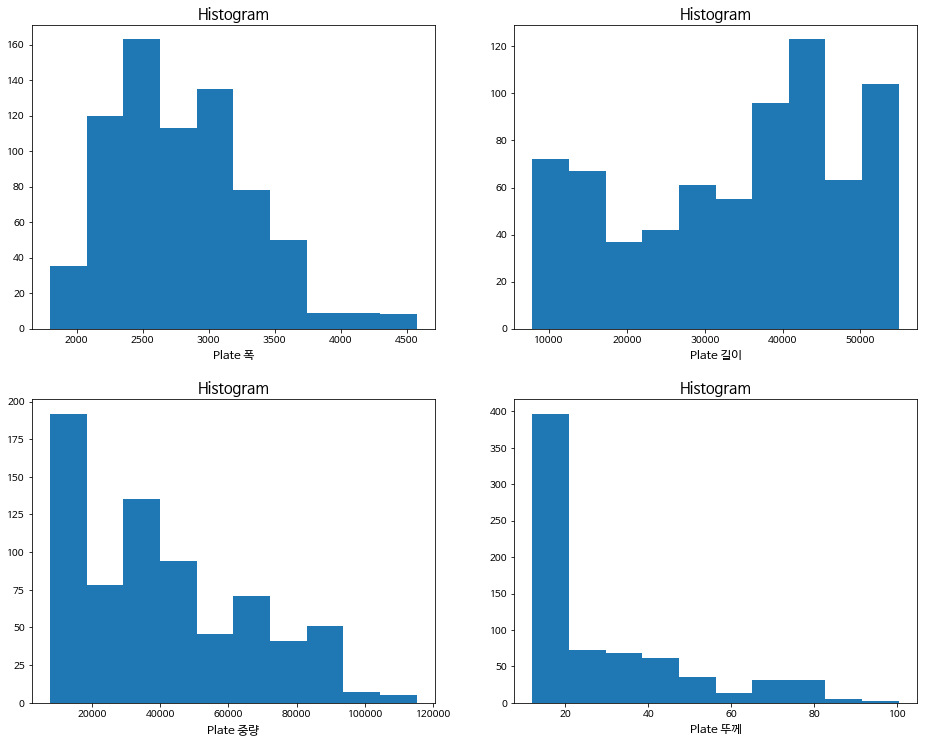

In [76]:
fig, axes = plt.subplots(nrows=2, ncols = 2, figsize = (13, 10)) #(2,2) 4분할, 4개의 그래프 생성
plt.tight_layout(w_pad=5, h_pad=5) #w_pad:열 사이 간격, h_pad: 행 사이 간격
#Histogram
axes[0,0].hist(ds_posco["PT_WDTH"]) #[0,0]위치에 histogram 생성
axes[0,0].set_title("Histogram", fontsize = 15) #제목 설정, 글자 크기 15
axes[0,0].set_xlabel("Plate 폭",fontsize = 12) #x축 label 지정
#
axes[0,1].hist(ds_posco["PT_LTH"]) #[0,0]위치에 histogram 생성
axes[0,1].set_title("Histogram", fontsize = 15) #제목 설정, 글자 크기 15
axes[0,1].set_xlabel("Plate 길이",fontsize = 12) #x축 label 지정
#
axes[1,0].hist(ds_posco["PT_WGT"]) #[0,0]위치에 histogram 생성
axes[1,0].set_title("Histogram", fontsize = 15) #제목 설정, 글자 크기 15
axes[1,0].set_xlabel("Plate 중량",fontsize = 12) #x축 label 지정
#
axes[1,1].hist(ds_posco["PT_THK"]) #[0,0]위치에 histogram 생성
axes[1,1].set_title("Histogram", fontsize = 15) #제목 설정, 글자 크기 15
axes[1,1].set_xlabel("Plate 뚜께",fontsize = 12) #x축 label 지정

#### plate의 폭의 경우 정규성 분포를 띄는것을 확인했으며 plate 두께의 경우는 대부분 20 밑에 분포하는 것을 확인하였다

Text(0.5, 69.00000000000009, '가열로 균열대 온도')

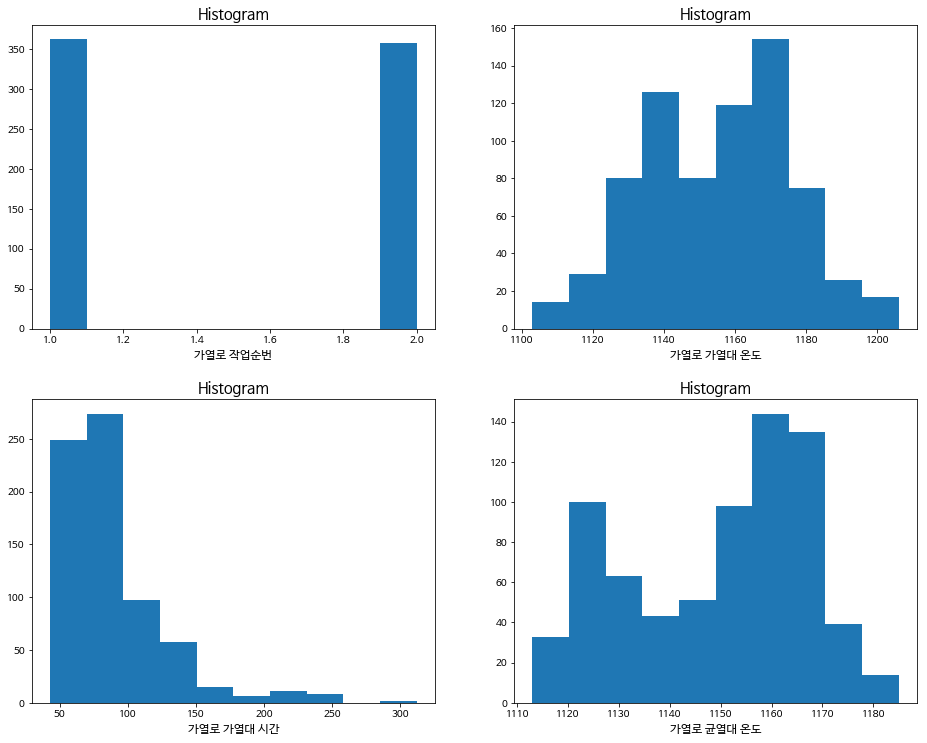

In [77]:
fig, axes = plt.subplots(nrows=2, ncols = 2, figsize = (13, 10)) #(2,2) 4분할, 4개의 그래프 생성
plt.tight_layout(w_pad=5, h_pad=5) #w_pad:열 사이 간격, h_pad: 행 사이 간격
#Histogram
axes[0,0].hist(ds_posco["FUR_NO_ROW"]) #[0,0]위치에 histogram 생성
axes[0,0].set_title("Histogram", fontsize = 15) #제목 설정, 글자 크기 15
axes[0,0].set_xlabel("가열로 작업순번",fontsize = 12) #x축 label 지정
#Pie Chart
axes[0,1].hist(ds_posco["FUR_HZ_TEMP"]) #[0,0]위치에 histogram 생성
axes[0,1].set_title("Histogram", fontsize = 15) #제목 설정, 글자 크기 15
axes[0,1].set_xlabel("가열로 가열대 온도",fontsize = 12) #x축 label 지정
#Trend
axes[1,0].hist(ds_posco["FUR_HZ_TIME"]) #[0,0]위치에 histogram 생성
axes[1,0].set_title("Histogram", fontsize = 15) #제목 설정, 글자 크기 15
axes[1,0].set_xlabel("가열로 가열대 시간",fontsize = 12) #x축 label 지정
#Scatter
axes[1,1].hist(ds_posco["FUR_SZ_TEMP"]) #[0,0]위치에 histogram 생성
axes[1,1].set_title("Histogram", fontsize = 15) #제목 설정, 글자 크기 15
axes[1,1].set_xlabel("가열로 균열대 온도",fontsize = 12) #x축 label 지정

#### 가열로 작업순번의 경우 1, 2만 존재하여 모두 동일한 분포를 띄는것을 확인하였다 따라서 크게 영향을 미치지 않을거라 생각하였다.

Text(0.5, 69.00000000000009, '가열대 온도')

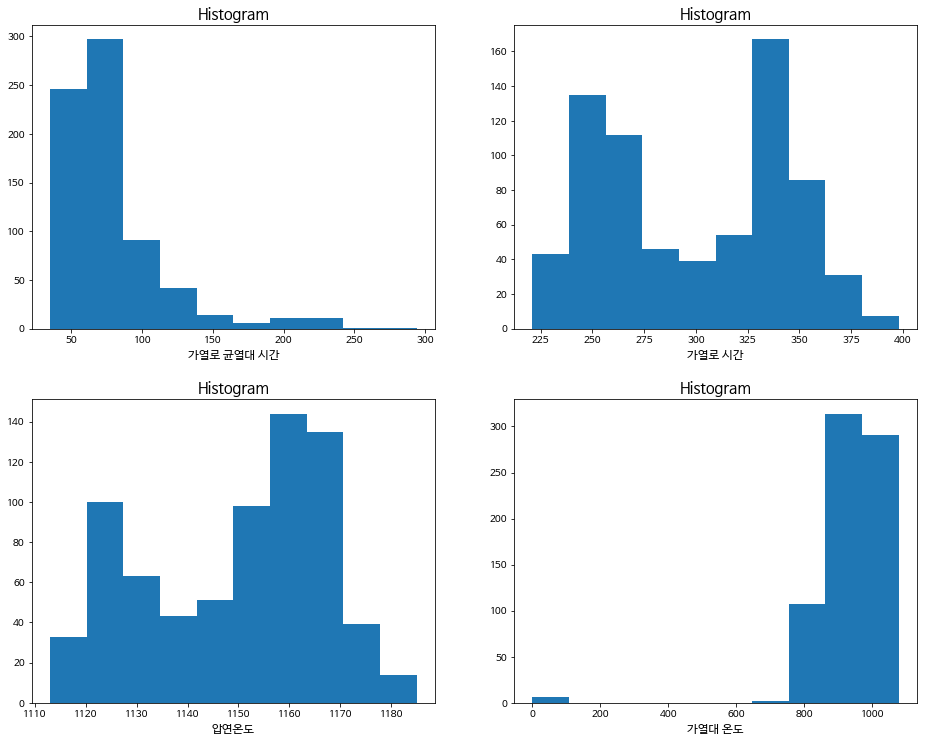

In [78]:
fig, axes = plt.subplots(nrows=2, ncols = 2, figsize = (13, 10)) #(2,2) 4분할, 4개의 그래프 생성
plt.tight_layout(w_pad=5, h_pad=5) #w_pad:열 사이 간격, h_pad: 행 사이 간격
#Histogram
axes[0,0].hist(ds_posco["FUR_SZ_TIME"]) #[0,0]위치에 histogram 생성
axes[0,0].set_title("Histogram", fontsize = 15) #제목 설정, 글자 크기 15
axes[0,0].set_xlabel("가열로 균열대 시간",fontsize = 12) #x축 label 지정
#Pie Chart
axes[0,1].hist(ds_posco["FUR_TIME"]) #[0,0]위치에 histogram 생성
axes[0,1].set_title("Histogram", fontsize = 15) #제목 설정, 글자 크기 15
axes[0,1].set_xlabel("가열로 시간",fontsize = 12) #x축 label 지정
#Trend
axes[1,0].hist(ds_posco["FUR_EXTEMP"]) #[0,0]위치에 histogram 생성
axes[1,0].set_title("Histogram", fontsize = 15) #제목 설정, 글자 크기 15
axes[1,0].set_xlabel("압연온도",fontsize = 12) #x축 label 지정
#Scatter
axes[1,1].hist(ds_posco["ROLLING_TEMP_T5"]) #[0,0]위치에 histogram 생성
axes[1,1].set_title("Histogram", fontsize = 15) #제목 설정, 글자 크기 15
axes[1,1].set_xlabel("가열대 온도",fontsize = 12) #x축 label 지정

#### 가열로 균열대 시간과 가열대 온도의 경우 한쪽으로 데이터가 치우친 것을 확인할 수 있다. 반면에 가열로 시간과 압연온도의 경우 데이터가 골고루 퍼진 것을 확인할 수 있다.

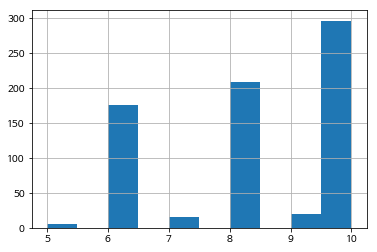

In [79]:
#탐색적분석 비소매업 비율
ds_posco["ROLLING_DESCALING"].hist()

In [80]:
ds_posco["SCALE"].replace(to_replace="불량", value=1, inplace = True)
ds_posco["SCALE"].replace(to_replace="양품", value=0, inplace = True)

#train 데이터셋 스케일 조정
# ds_posco_x_scaled = scale(ds_posco_x, axis = 0)
#스케일이 변경된 X변수 확인
# pd.DataFrame(ds_posco_x_scaled, columns = ds_posco_x.columns).head()


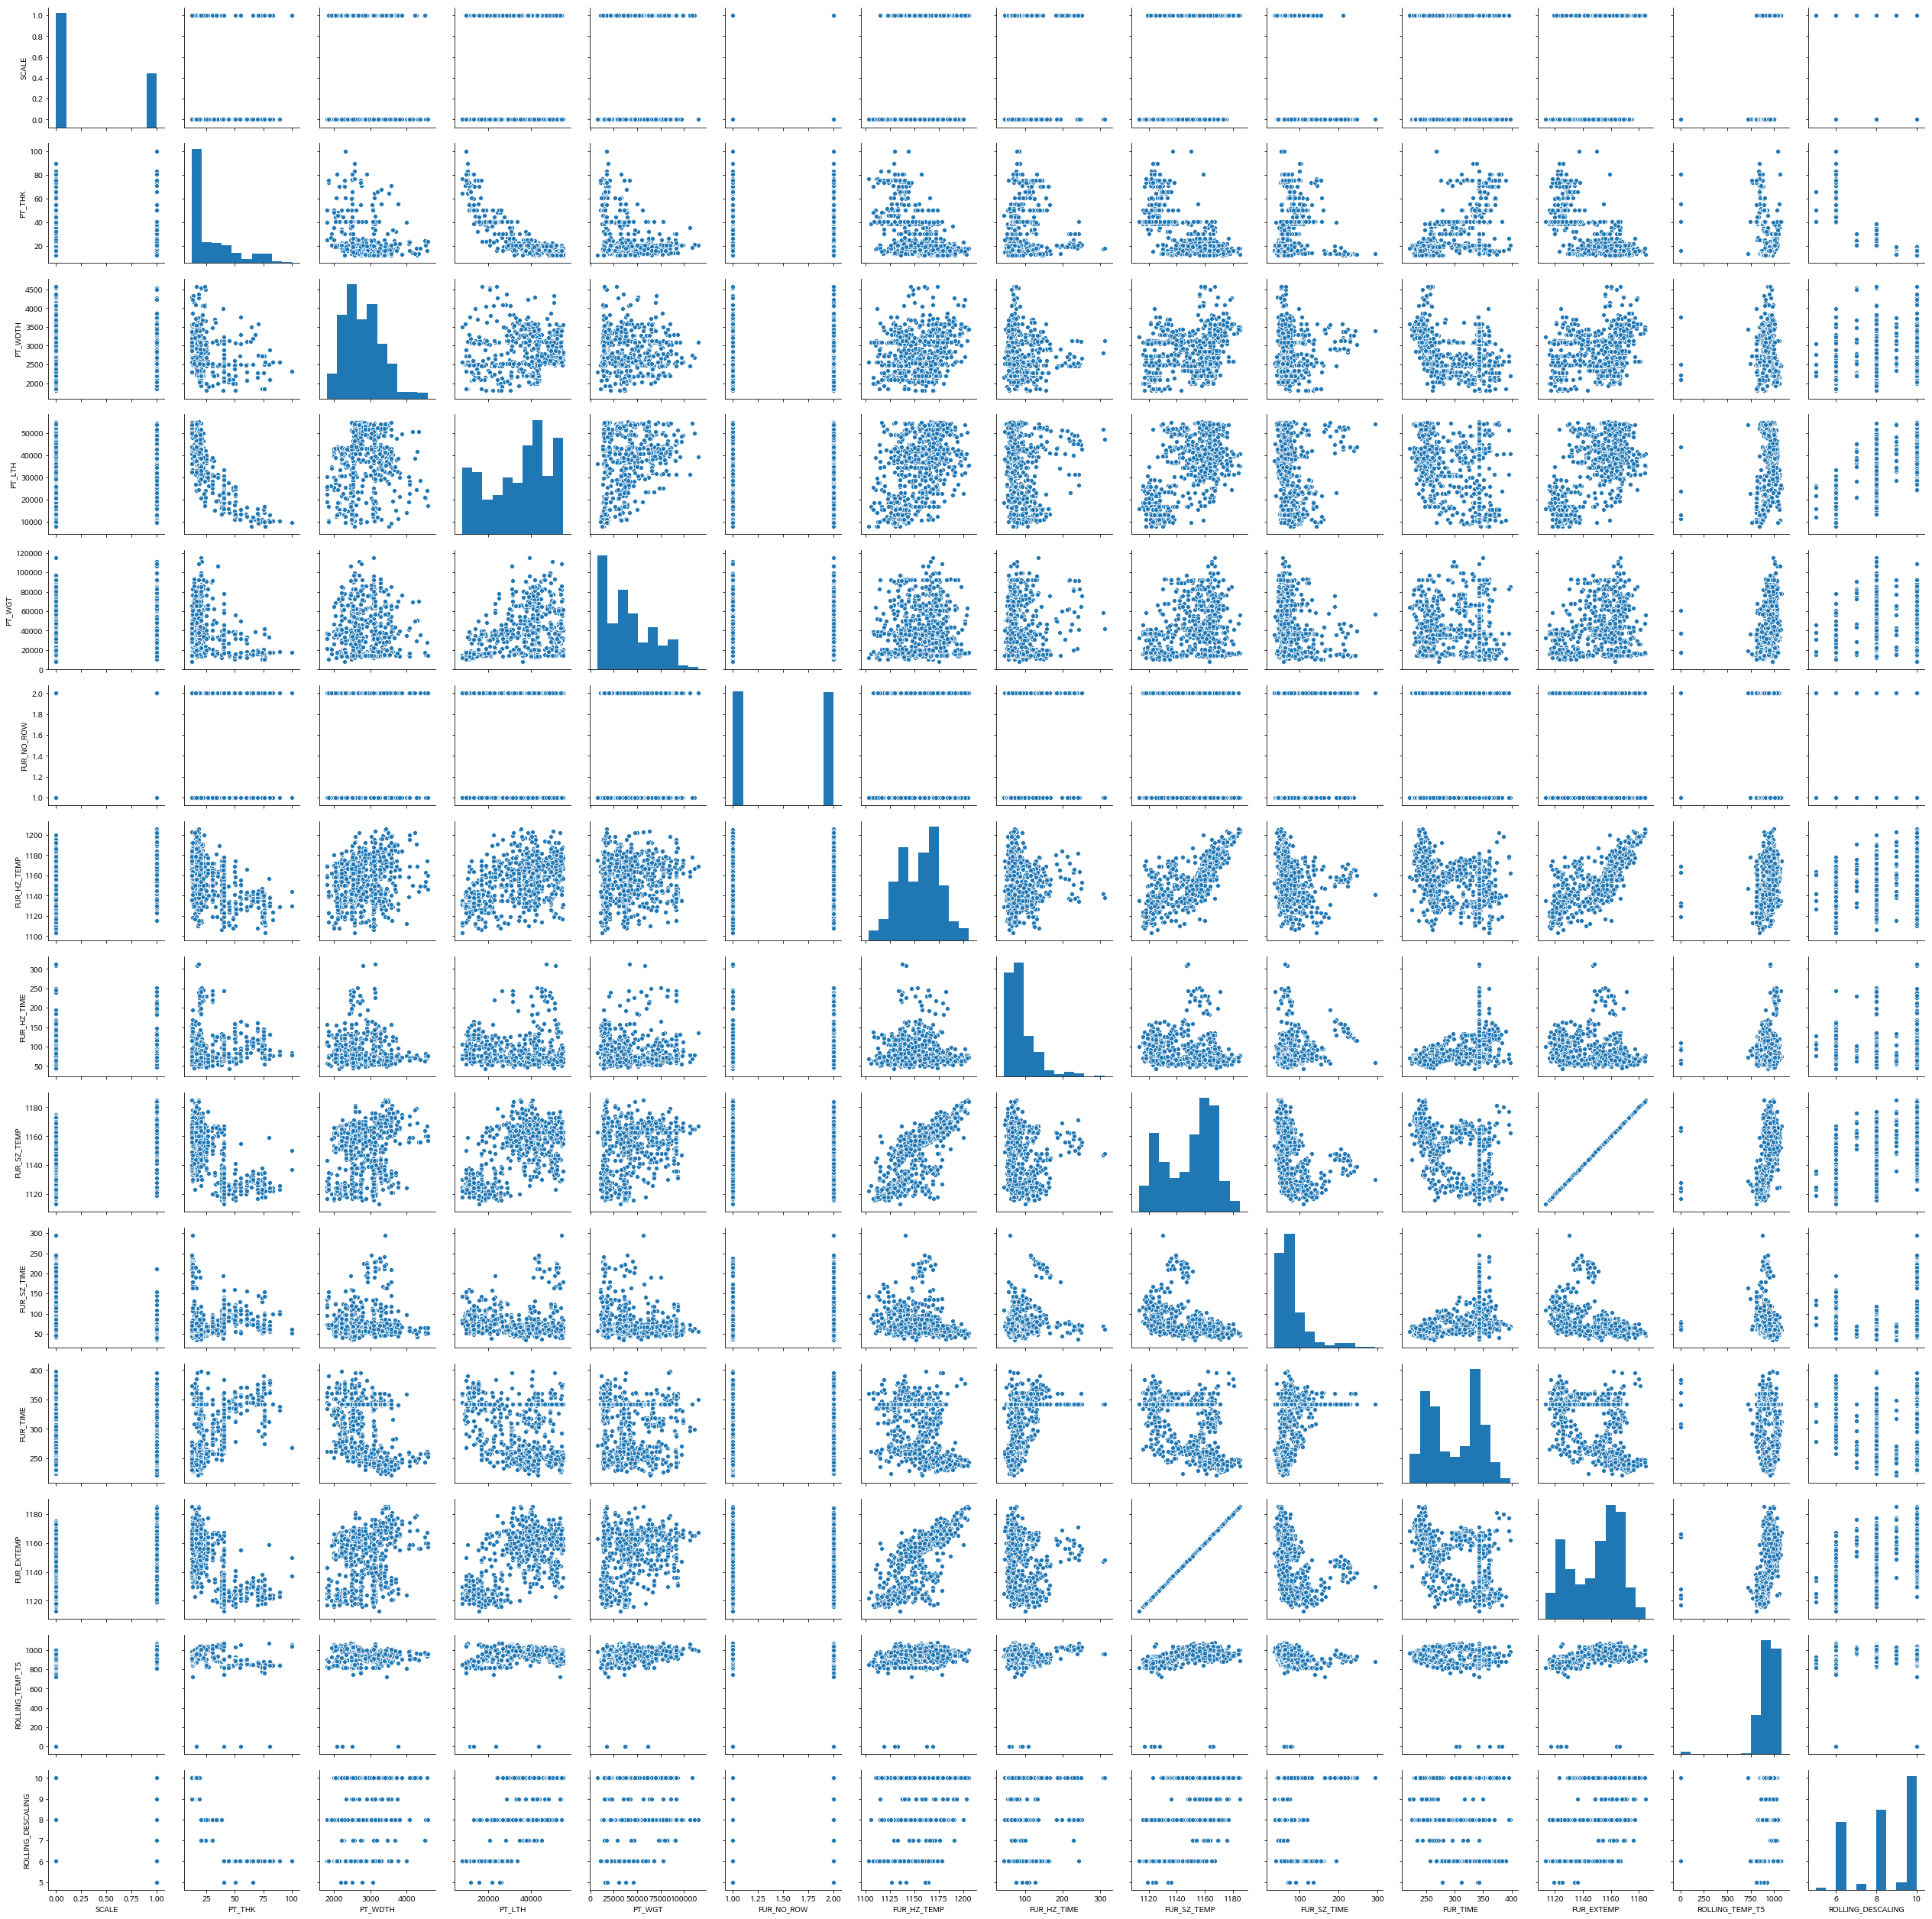

In [81]:
#2.변수 간의 경향성 파악 - 그래프 분석
sns.pairplot(ds_posco)

In [82]:
#2-2 변수 간의 경향성 파악 - 상관관계 분석
#상관관계 분석
ds_posco.corr().round(3)

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
SCALE,1.000,-0.125,-0.206,0.100,0.219,-0.023,0.248,0.056,0.375,-0.240,-0.049,0.375,0.385,-0.007
PT_THK,-0.125,1.000,-0.313,-0.863,-0.397,-0.003,-0.524,0.160,-0.695,0.113,0.413,-0.695,-0.374,-0.837
PT_WDTH,-0.206,-0.313,1.000,0.120,0.031,0.007,0.180,-0.119,0.227,0.023,-0.393,0.227,-0.022,0.338
PT_LTH,0.100,-0.863,0.120,1.000,0.452,-0.021,0.473,-0.077,0.645,-0.070,-0.252,0.645,0.313,0.809
PT_WGT,0.219,-0.397,0.031,0.452,1.000,-0.022,0.153,0.010,0.360,-0.191,-0.058,0.360,0.263,0.239
FUR_NO_ROW,-0.023,-0.003,0.007,-0.021,-0.022,1.000,0.005,-0.016,0.009,0.049,0.016,0.009,-0.004,0.018
FUR_HZ_TEMP,0.248,-0.524,0.180,0.473,0.153,0.005,1.000,-0.114,0.773,-0.222,-0.348,0.773,0.265,0.471
FUR_HZ_TIME,0.056,0.160,-0.119,-0.077,0.010,-0.016,-0.114,1.000,-0.203,0.178,0.473,-0.203,0.012,-0.138
FUR_SZ_TEMP,0.375,-0.695,0.227,0.645,0.360,0.009,0.773,-0.203,1.000,-0.451,-0.477,1.000,0.452,0.649
FUR_SZ_TIME,-0.240,0.113,0.023,-0.070,-0.191,0.049,-0.222,0.178,-0.451,1.000,0.443,-0.451,-0.207,-0.106


#### 상관관계 분석을 통하여 변수들 간에 다중공선성이 존재하는지 유추할 수 있다.
#### 예를들어 ROLLING_DESCALING PT_LTH 경우 0.809인데 수치가 매우 높은 것을 알수 있다.
#### 또한 FUR_SZ_TEMP, PT_LTH 간에 상관계수도 0.645인것을 확인할 수 있다.

In [83]:
#from_formula 함수를 이용하여 변수 역할 지정
#C(SPEC) + C(STEEL_KIND)
# log_model = sm.Logit.from_formula("""SCALE ~  C(SPEC) + C(STEEL_KIND) + PT_THK + PT_WDTH + PT_LTH + PT_WGT + C(FUR_NO) + FUR_HZ_TEMP + FUR_HZ_TIME + FUR_SZ_TEMP + FUR_SZ_TIME + FUR_TIME + FUR_EXTEMP + ROLLING_TEMP_T5 + C(HSB) + ROLLING_DESCALING+ C(WORK_GR) + 1""", ds_posco)
log_model = sm.Logit.from_formula("""SCALE ~  PT_THK + PT_WDTH + PT_LTH + PT_WGT + C(FUR_NO) + FUR_HZ_TEMP + FUR_HZ_TIME + FUR_SZ_TEMP + FUR_SZ_TIME + FUR_TIME + FUR_EXTEMP + ROLLING_TEMP_T5 + C(HSB) + ROLLING_DESCALING+ C(WORK_GR) + 1""", ds_posco)
log_result = log_model.fit()
#결과 출력
print(log_result.summary())


         Current function value: 0.268139
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  720
Model:                          Logit   Df Residuals:                      702
Method:                           MLE   Df Model:                           17
Date:                Mon, 18 Feb 2019   Pseudo R-squ.:                  0.5727
Time:                        02:33:40   Log-Likelihood:                -193.06
converged:                      False   LL-Null:                       -451.80
                                        LLR p-value:                 3.926e-99
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -89.2123   8232.257     -0.011      0.991   -1.62e+04     1.6e+04
C(FUR_NO)[T.2호기]     -0.2384      0.334     

/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


#### Logistic 회기분석결과 nan이 뜨는것을 확인했음.. (why?)

### Logistic 회귀계수 검정 -> 유의수준 P>|z| 0.05보다 작은 유의한 변수들은
### PT_WDTH, PT_LTH, FUR_HZ_TEMP, FUR_HZ_TIME, ROLLING_TEMP_T5, FUR_SZ_TIME, ROLLING_DESCALING

In [84]:
#ds_posco["WORK_GR"].replace(to_replace="미적용", value=0, inplace = True)
ds_posco_new = pd.DataFrame()
ds_posco_new["SCALE"] = ds_posco.SCALE
ds_posco_new["PT_WDTH"] = ds_posco.PT_WDTH
ds_posco_new["PT_LTH"] = ds_posco.PT_LTH
ds_posco_new["FUR_HZ_TEMP"] = ds_posco.FUR_HZ_TEMP
ds_posco_new["FUR_HZ_TIME"] = ds_posco.FUR_HZ_TIME
ds_posco_new["ROLLING_TEMP_T5"] = ds_posco.ROLLING_TEMP_T5
ds_posco_new["FUR_SZ_TIME"] = ds_posco.FUR_SZ_TIME
ds_posco_new["ROLLING_DESCALING"] = ds_posco.ROLLING_DESCALING

ds_posco_new.head()

,SCALE,PT_WDTH,PT_LTH,FUR_HZ_TEMP,FUR_HZ_TIME,ROLLING_TEMP_T5,FUR_SZ_TIME,ROLLING_DESCALING
0,0,3707,15109,1144,116,934,59,8
1,0,3707,15109,1144,122,937,53,8
2,0,3619,19181,1129,116,889,55,8
3,0,3619,19181,1152,125,885,68,8
4,0,3098,13334,1140,134,873,48,8


해당 요소외에는 모델을 만들어서 분석해야 하므로 모두 제외시킨다.

In [85]:
ds_posco_y = ds_posco_new["SCALE"]
ds_posco_x = ds_posco_new.drop("SCALE", axis = 1, inplace = False)

#get_dummies : 데이터의 문자형 컬럼에 대한 더미변수 생성
ds_posco_dummy = pd.get_dummies(ds_posco_new)
#더미변수 생성된 데이터의 상위 5개 row를 확인
ds_posco_dummy.head()

,SCALE,PT_WDTH,PT_LTH,FUR_HZ_TEMP,FUR_HZ_TIME,ROLLING_TEMP_T5,FUR_SZ_TIME,ROLLING_DESCALING
0,0,3707,15109,1144,116,934,59,8
1,0,3707,15109,1144,122,937,53,8
2,0,3619,19181,1129,116,889,55,8
3,0,3619,19181,1152,125,885,68,8
4,0,3098,13334,1140,134,873,48,8


핵심인자를 바탕으로 디시전트리 진행

In [86]:
#train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size = test 데이터비율, random_state : 랜덤)
ds_posco_train_x, ds_posco_test_x, ds_posco_train_y, ds_posco_test_y =\
train_test_split(ds_posco_x, ds_posco_y, test_size = 0.30, random_state = 1234)

print("train data X size : {}".format(ds_posco_train_x.shape))
print("train data Y size : {}".format(ds_posco_train_y.shape))
print("test data X size : {}".format(ds_posco_test_x.shape))
print("test data Y size : {}".format(ds_posco_test_y.shape))

train data X size : (504, 7)
train data Y size : (504,)
test data X size : (216, 7)
test data Y size : (216,)


## 디시전트리

In [87]:
###의사결정 나무
#sklearn.tree 의 DecisionTreeClassifier : 분류의사결정나무
from sklearn.tree import DecisionTreeClassifier
#sklearn.tree의 export_graphviz : grahviz 패키지가 사용할 수 있는 .dot 확장자 파일로 저장
from sklearn.tree import export_graphviz
#graphviz import : 의사결정 나무 모델 시각화 .dot 확장자 파일 불러오는 패키지
import graphviz

In [88]:
tree_uncustomized = DecisionTreeClassifier(random_state = 1234)
tree_uncustomized.fit(ds_posco_train_x, ds_posco_train_y)

#훈련 데이터 정확도
print("Accucary on training set : {:.3f}".format(tree_uncustomized.score(ds_posco_train_x, ds_posco_train_y)))
#test 데이터 정확도
print("Accucary on test set: {:.3f}".format(tree_uncustomized.score(ds_posco_test_x, ds_posco_test_y)))

Accucary on training set : 1.000
Accucary on test set: 0.884


랜덤값으로 디시전 트리를 만들어 test데이터와 비교를 하였다. Accucary는 0.884가 나왔다.

In [89]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
param_grid = {'max_depth': np.arange(1, 100)}

#gridSearchCV를 이용하여 의사결정트리
crit = ['gini','entropy']
for atom in crit:
    tree = GridSearchCV(DecisionTreeClassifier(criterion=atom), param_grid)
    tree.fit(ds_posco_train_x, ds_posco_train_y)
    tree_preds = tree.predict_proba(ds_posco_test_x)[:, 1]
    tree_performance = roc_auc_score(ds_posco_test_y, tree_preds)
    print('DecisionTree: Area under the ROC curve = {}'.format(tree_performance))

/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


DecisionTree: Area under the ROC curve = 0.8710539096648859


/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


DecisionTree: Area under the ROC curve = 0.8350169985429821


param_grid에 범위가 1~100까지 각각의 max_depth에 마다 gini, entropy 방식으로 의사결정트리를 만들고 그 가운데 최적의 트리를 만들어주는것이 GridSearchCV의 기능이다. 이렇게 나온 의사결정트리는 best_estimator를 이용하여 fit하고 graphviz로 그려보았다

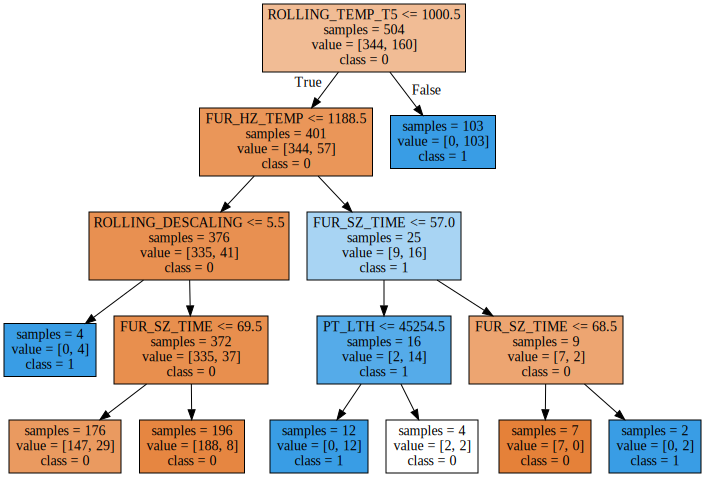

In [90]:
#graphviz 패키지로 트리 모델 시각화
tree.best_estimator_.fit(ds_posco_train_x, ds_posco_train_y)
export_graphviz(tree.best_estimator_, out_file = "tree.dot", class_names=["0","1"], feature_names = ds_posco_train_x.columns, impurity=False, filled = True)

os.environ["PATH"]+= os.pathsep + "./.wine/drive_c/Program Files (x86)/Graphviz2.38/bin/"

with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

#### 위와같이 디시전 트리를 만들었다.
#### 트리는 부모 노드에서 해당 요소가 ex) ROLING_TEMP_T5가 1000.5보다 작거나 같으면 True, 아니면 False로 분류하는식이다.
#### 노드의 samples는 해당 노드의 전체 자료 수이고 value는 0과 1의 각각의 자료수 순수노드가 아닐 경우 자료가 많은쪽으로 class를 분류한다.
#### 보는바와 같이 ROLLING_TEMP_T5와 ROLLING_DESCALING, FUR_HZ_TEMP의 영향이 큰것을 알 수 있다.

## 랜덤포레스트

In [91]:
#랜덤 포레스트 모델 생성 : RandomForestClassifier
rf_uncustomized = RandomForestClassifier(random_state = 1234)
rf_uncustomized.fit(ds_posco_train_x, ds_posco_train_y)

/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

임의의 랜덤 포레스트를 만들었다. min_samples_leaf=1, n_estimators = 10

In [92]:
#train 데이터셋 스케일 조정
ds_posco_train_x_scaled = scale(ds_posco_train_x, axis = 0)
# test 데이터셋 스케일 조정
ds_posco_test_x_scaled = scale(ds_posco_test_x, axis = 0)
#스케일이 변경된 X변수 확인
pd.DataFrame(ds_posco_train_x_scaled, columns = ds_posco_train_x.columns).head()

/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  
/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.


,PT_WDTH,PT_LTH,FUR_HZ_TEMP,FUR_HZ_TIME,ROLLING_TEMP_T5,FUR_SZ_TIME,ROLLING_DESCALING
0,0.932426,1.241863,-0.611378,-0.361454,-0.132949,1.194445,1.043935
1,0.632792,-1.285409,-1.088589,-0.693281,-0.438124,0.830529,-0.179654
2,-0.992966,-0.236699,-0.086447,-0.389106,0.749583,0.410627,-0.179654
3,-0.587010,-1.588275,-0.849983,0.578721,-0.660819,-0.177237,-1.403243
4,-1.665694,0.056576,-1.708962,1.159418,-0.025726,-0.401185,-0.179654


In [93]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV                                                                                                                                                                                                                                                                                                                                               
from sklearn.metrics import roc_auc_score
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': np.arange(2, 10), 'min_samples_leaf': np.arange(1, 5),'n_estimators': np.arange(1, 15, 3)} 
#gridSearchCV를 이용하여 랜덤포레스트의 최적을 찾는다.
rf = GridSearchCV(rf_uncustomized, param_grid, n_jobs = 8)
rf.fit(ds_posco_train_x_scaled, ds_posco_train_y)

/home/pirl/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'min_samples_leaf': array([1, 2, 3, 4]), 'n_estimators': array([ 1,  4,  7, 10, 13]), 'criterion': ['gini', 'entropy'], 'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [94]:
rf.score(ds_posco_train_x_scaled, ds_posco_train_y), rf.best_score_, rf.best_params_

(0.9543650793650794,
 0.9047619047619048,
 {'criterion': 'entropy',
  'max_depth': 7,
  'min_samples_leaf': 2,
  'n_estimators': 13})

최적의 모델이 위와같이 나왔다 max_depth = 4, min_samples_leaf = 7, n_estimators = 36, criterion이 entropy일때 
가장 최적의 모델이다.

In [95]:
final=RandomForestClassifier(criterion='entropy', max_depth=4, min_samples_leaf=7, n_estimators=36, random_state = 1234)
final.fit(ds_posco_train_x_scaled, ds_posco_train_y)

print("train accuracy:{0:.3f}".format(final.score(ds_posco_train_x_scaled,ds_posco_train_y)))
print("test accuracy:{0:.3f}".format(final.score(ds_posco_test_x_scaled,ds_posco_test_y)))

train accuracy:0.907
test accuracy:0.792


### 의 경우 최적의 모델을 찾는 GridSearchCV를 통하여 조건을 찾고 실제 test데이터와 비교해본 결과 0.792라는 정확도를 얻었다.

train데이터와 test데이터가 위와같이 나왔다. 연습시간에 했던 랜덤포레스트를 그래프로 max_depth, criterion때마다 돌려서
시각적으로 최적의 값을 찾았는데, 위의 train데이터와 test의 가장 최적인것을 확인한다.

In [96]:
rf.best_estimator_.fit(ds_posco_train_x_scaled, ds_posco_train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=13, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

## Gradient Boosting

In [97]:
#그래디언트 부스팅 모델 생성 : GradientBoostingClassifier
gb_uncustomized = GradientBoostingClassifier(random_state = 1234)
gb_uncustomized.fit(ds_posco_train_x, ds_posco_train_y)
#훈련 데이터 셋 정확도
print("Accucary on training set: {:.3f}".format(gb_uncustomized.score(ds_posco_train_x, ds_posco_train_y)))
#테스트 데이터 셋 정확도
print("Accucary on test set: {:.3f}".format(gb_uncustomized.score(ds_posco_test_x, ds_posco_test_y)))

Accucary on training set: 0.982
Accucary on test set: 0.935


In [98]:
gb_uncustomized

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=1234,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [99]:
gb_scaled = GradientBoostingClassifier(random_state=1234)
gb_scaled.fit(ds_posco_train_x_scaled, ds_posco_train_y)
#훈련 데이터 셋 정확도
print("Accucary on training set:{:.3f}".format(gb_scaled.score(ds_posco_train_x_scaled, ds_posco_train_y)))
#테스트 데이터 셋 정확도
print("Accucary on test set:{:.3f}".format(gb_scaled.score(ds_posco_test_x_scaled, ds_posco_test_y)))

Accucary on training set:0.982
Accucary on test set:0.806


In [100]:
#트레인 및 테스트 정확도 결과 저장용
train_accuracy = []
test_accuracy = []
#트리 최대수(1~30)별로 랜덤 포레스트 모델 생성 및 정확도값 저장
for lr in range(1, 100, 5):
    gb1 = GradientBoostingClassifier(learning_rate = lr/100, random_state = 1234)
    gb1.fit(ds_posco_train_x_scaled, ds_posco_train_y)
    train_accuracy.append(gb1.score(ds_posco_train_x_scaled, ds_posco_train_y))
    test_accuracy.append(gb1.score(ds_posco_test_x_scaled, ds_posco_test_y))
#저장된 모델의 트레인/테스트 데이터 분류 정확도 테이블 생성
ds_accuracy1 = pd.DataFrame()
ds_accuracy1["LearningRate"] = [lr/100 for lr in range(1, 100, 5)]
ds_accuracy1["TrainAccuracy"] = train_accuracy
ds_accuracy1["TestAccuracy"] = test_accuracy

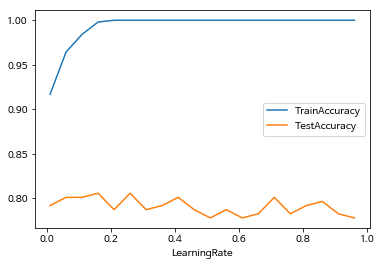

In [101]:
#LearningRate 별 정확도 테이블
ds_accuracy1.round(3)
#LearningRate별 정확도 그래프로 확인
ds_accuracy1.set_index("LearningRate", inplace = False).plot.line()

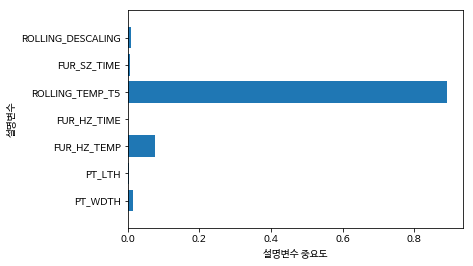

In [102]:
#최종 모델
gb_model = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 4, min_samples_leaf = 30, n_estimators = 5, random_state = 1234)
gb_model.fit(ds_posco_train_x_scaled, ds_posco_train_y)
#gb_model.feature_importances_로 설명변수 중요도 확인
ds_feature_importance = pd.DataFrame()
ds_feature_importance["feature"] = ds_posco_train_x.columns
ds_feature_importance["importance"] = gb_model.feature_importances_
ds_feature_importance.sort_values(by="importance", ascending=False).round(3)

#설명변수 중요도 그리는 함수 정의
def plot_feature_importances(model):
    n_features = ds_posco_train_x.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align="center")
    plt.yticks(np.arange(n_features), ds_posco_train_x.columns)
    plt.xlabel("설명변수 중요도")
    plt.ylabel("설명변수")
    plt.ylim(-1, n_features)

#설명변수 중요도 그리는 함수 실행
plot_feature_importances(gb_model)

#### Gradient Boosting을 조건 learning_rate = 0.1, max_depth = 4, min_samples_leaf = 30, n_estimators = 5의 조건을 주고
#### 선정한 각 설명변수에 대한 중요도를 확인하였다.
#### 보는바와 같이 설명변수들 중, ROLLING_TEMP_T5가 0.8 이상 가장 큰 중요도를 가지는 것을 확인하였다.

## KNN 모델 

In [103]:
# KNN 패키지
from sklearn.neighbors import KNeighborsClassifier
#KNN모델 생성(default 설정)
knn_uncusotomized = KNeighborsClassifier(n_jobs = 8)
knn_uncusotomized

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=8, n_neighbors=5, p=2,
           weights='uniform')

In [104]:
#데이터 적합
knn_uncusotomized.fit(ds_posco_train_x, ds_posco_train_y)
#test 데이터로 예측
y_pred = knn_uncusotomized.predict(ds_posco_test_x)
print("predict test set:{}".format(y_pred.tolist()[:10]))
print("test set label:{}".format(ds_posco_test_y.tolist()[:10]))
print("accuracy:{0:.3f}".format(knn_uncusotomized.score(ds_posco_test_x, ds_posco_test_y)))


predict test set:[0, 0, 0, 1, 0, 1, 0, 1, 0, 1]
test set label:[1, 1, 0, 1, 0, 0, 0, 0, 1, 0]
accuracy:0.704


In [105]:
#최대 이웃 수
max_n_neighbors = 30  # 반복 수행할 리스트(1~10)
para_n_neighbors = [i+1 for i in range(max_n_neighbors)]
train_accuracy = []
test_accuracy = []
#반복문
for n_neighbors in para_n_neighbors:
    #이웃 1~10개까지 지정하여 모델 생성
    clf = KNeighborsClassifier(n_neighbors = n_neighbors)
    clf.fit(ds_posco_train_x, ds_posco_train_y)
    #train data 정확도
    train_accuracy.append(clf.score(ds_posco_train_x, ds_posco_train_y))
    #test data 정확도
    test_accuracy.append(clf.score(ds_posco_test_x, ds_posco_test_y))
#DataFrame 변환
ds_neighbors = pd.DataFrame()
ds_neighbors["Neighbors"] = para_n_neighbors
ds_neighbors["TrainAccuracy"] = train_accuracy
ds_neighbors["TestAccuracy"] = test_accuracy
ds_neighbors

,Neighbors,TrainAccuracy,TestAccuracy
0,1,1.000000,0.717593
1,2,0.859127,0.731481
2,3,0.859127,0.708333
3,4,0.811508,0.722222
4,5,0.799603,0.703704
5,6,0.793651,0.726852
6,7,0.803571,0.731481
7,8,0.781746,0.731481
8,9,0.781746,0.745370
9,10,0.761905,0.731481


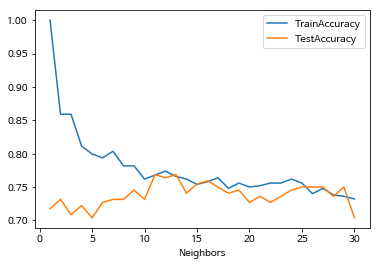

In [106]:
#그래프 생성
ds_neighbors.set_index("Neighbors", inplace = False).plot()

약 30개의 neighbor 를 하여 test와 training 데이터를 진행하였고, 약 11개의 neighbor일 때, testAccuracy의 성능이 가장 높은것을 알 수 있다.참고로 neighbor이 낮을땐 과대적합, neighbor이 높아질수록 과소적합이 된다.
따라서 최적의 이웃 수는 11개라고 할 수 있다.

## 주성분 분석

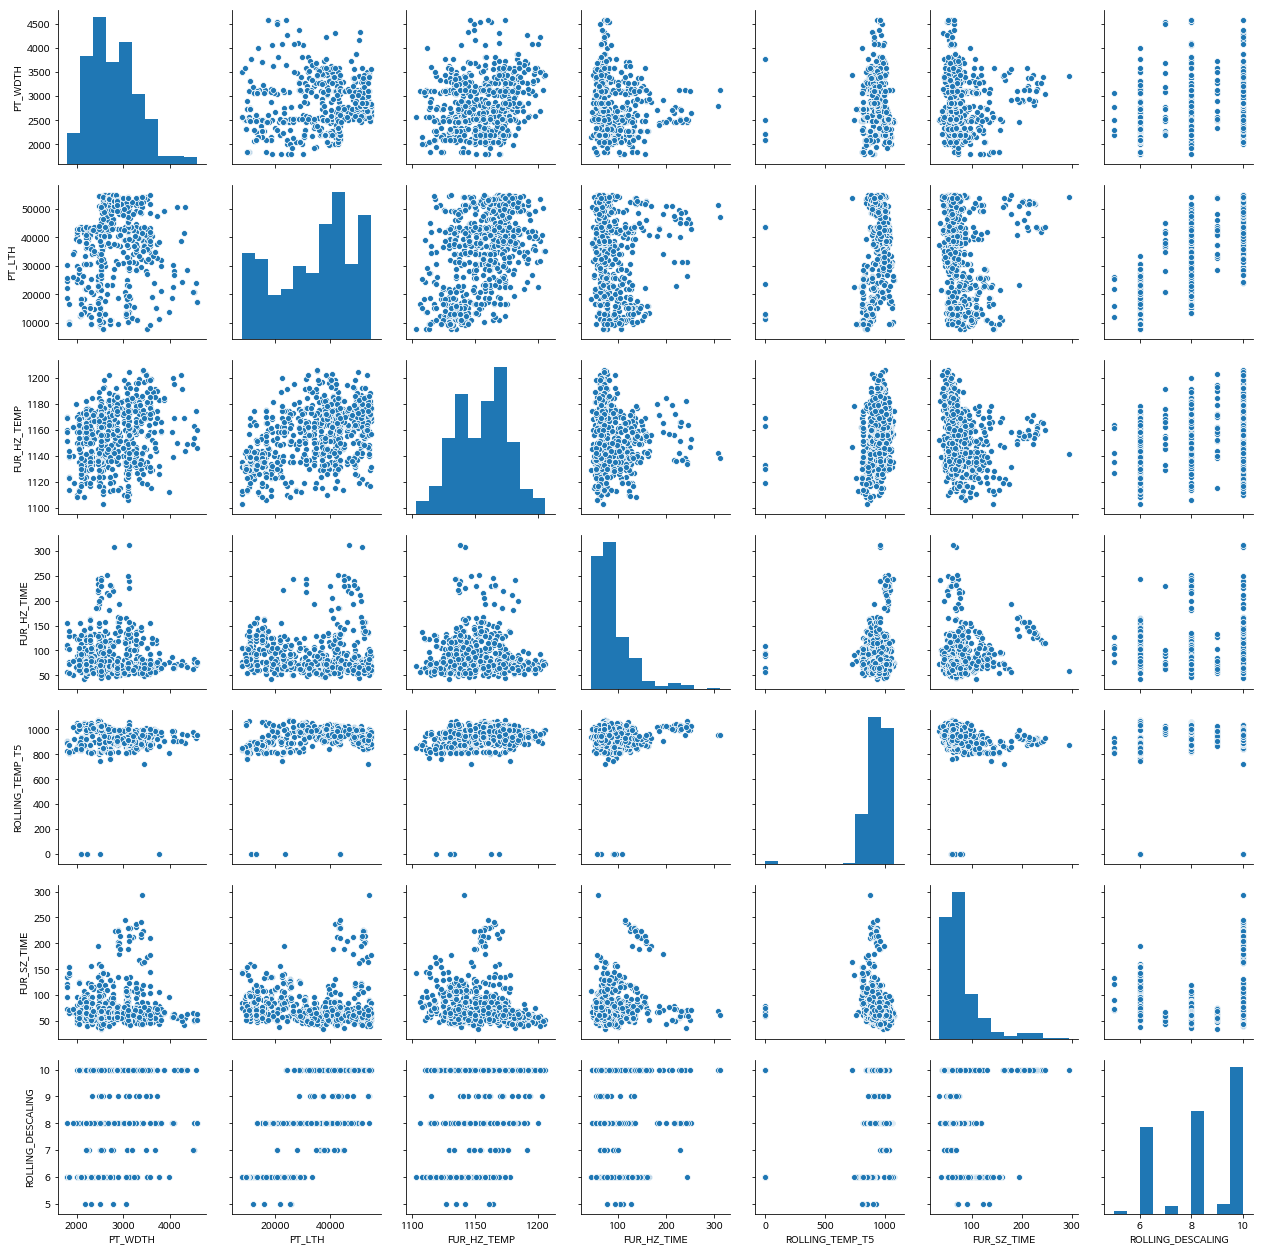

In [107]:
#산점도 행렬
sns.pairplot(ds_posco_x)
#주성분 분석
from sklearn.decomposition import PCA

In [108]:
ds_posco_x

,PT_WDTH,PT_LTH,FUR_HZ_TEMP,FUR_HZ_TIME,ROLLING_TEMP_T5,FUR_SZ_TIME,ROLLING_DESCALING
0,3707,15109,1144,116,934,59,8
1,3707,15109,1144,122,937,53,8
2,3619,19181,1129,116,889,55,8
3,3619,19181,1152,125,885,68,8
4,3098,13334,1140,134,873,48,8
5,3098,13334,1143,127,874,57,8
6,3099,16719,1138,126,878,50,8
7,3099,16719,1139,126,870,52,8
8,3099,16719,1127,126,873,52,8
9,3129,16187,1135,119,881,73,8


In [109]:
#상관계수
ds_posco_x.corr()

,PT_WDTH,PT_LTH,FUR_HZ_TEMP,FUR_HZ_TIME,ROLLING_TEMP_T5,FUR_SZ_TIME,ROLLING_DESCALING
PT_WDTH,1.000000,0.119726,0.180024,-0.119175,-0.021807,0.022627,0.337540
PT_LTH,0.119726,1.000000,0.473111,-0.077392,0.312762,-0.070225,0.809280
FUR_HZ_TEMP,0.180024,0.473111,1.000000,-0.114395,0.265310,-0.222141,0.470899
FUR_HZ_TIME,-0.119175,-0.077392,-0.114395,1.000000,0.011609,0.177922,-0.137742
ROLLING_TEMP_T5,-0.021807,0.312762,0.265310,0.011609,1.000000,-0.207358,0.267521
FUR_SZ_TIME,0.022627,-0.070225,-0.222141,0.177922,-0.207358,1.000000,-0.105667
ROLLING_DESCALING,0.337540,0.809280,0.470899,-0.137742,0.267521,-0.105667,1.000000


In [111]:
#주성분 분석 모델 생성. Prin 1~4까지
pca = PCA(n_components = 7)
#Prin 1~6까지의 새로운 변수 값을 생성
x_pca = pca.fit_transform(ds_posco_x)
# 계산된 Prin 1~6 주성분 변수의 5번째 값까지 확인
print("PCA Data :\n {}".format(x_pca[:3]))
#Shape : Prin 1~6까지의 Row개수, Column개수 확인
print("Shape :\n {}".format(x_pca.shape))
#주성분 점수 저장. Prin 1~6까지
ds_x_pca = pd.DataFrame(x_pca, columns = ["Prin1", "Prin2", "Prin3","Prin4","Prin5", "Prin6", "Prin7"])


PCA Data :
 [[ 1.92099829e+04  9.85151642e+02 -6.18609356e+01  1.15536859e+01
  -3.50466911e+01  6.25974392e+00 -7.61801520e-01]
 [ 1.92099758e+04  9.85050045e+02 -6.53830469e+01  1.26587540e+01
  -4.32253174e+01  6.94767871e+00 -7.61966227e-01]
 [ 1.51385521e+04  8.79497479e+02 -5.48261309e+00  8.89973615e+00
  -3.98419168e+01  2.28090152e+01 -5.49490308e-01]]
Shape :
 (720, 7)


In [119]:
#주성분 통계량 입력용 새로운 데이터 프레임 생성
ds_pca = pd.DataFrame()
#주성분 분석 모델의 주성부 번호, Eigenvalue, Eigenvalue ratio 등을 데이터 프레임의 형태로 저장
ds_pca["Prin"] = [I for I in range(1,8)]
ds_pca["EigenValues"] = pca.explained_variance_##Eigen values
ds_pca["EigenValueRatio"] = pca.explained_variance_ratio_ ##Eigen values ratio
ds_pca["CumsumEigenValueRatio"] = np.cumsum(pca.explained_variance_ratio_)
ds_pca.round(3)

,Prin,EigenValues,EigenValueRatio,CumsumEigenValueRatio
0,1,1.912307e+08,0.999,0.999
1,2,2.643776e+05,0.001,1.000
2,3,1.051920e+04,0.000,1.000
3,4,1.595840e+03,0.000,1.000
4,5,1.074121e+03,0.000,1.000
5,6,3.063610e+02,0.000,1.000
6,7,7.340000e-01,0.000,1.000


In [120]:
#주성분 통계량 입력용 새로운 데이터 프레임 생성
ds_feature = pd.DataFrame({"Feature": ds_posco_x.columns})
#주성분 Prin 1~6까지의 고유벡터 저장
ds_eigenvectors = pd.concat([ds_feature, 
                            pd.DataFrame(pca.components_, columns = ["Prin1","Prin2","Prin3","Prin4","Prin5","Prin6","Prin7"])], axis = 1)
ds_eigenvectors

,Feature,Prin1,Prin2,Prin3,Prin4,Prin5,Prin6,Prin7
0,PT_WDTH,-0.004490,-0.999987,-0.000714,0.000211,-0.002440,0.000185,-0.000095
1,PT_LTH,0.999856,-0.004462,0.005033,-0.008155,-0.013052,0.002252,0.000765
2,FUR_HZ_TEMP,-0.013113,0.002522,-0.028600,-0.010605,-0.996379,0.078224,-0.000516
3,FUR_HZ_TIME,0.006002,0.000214,-0.093025,0.780051,0.042750,0.617248,-0.002708
4,ROLLING_TEMP_T5,-0.005507,-0.000075,-0.083730,-0.625246,0.069799,0.772757,-0.000510
5,FUR_SZ_TIME,0.005361,0.000611,-0.991700,-0.020125,0.018769,-0.125396,-0.004486
6,ROLLING_DESCALING,0.000734,0.000087,0.004762,-0.001704,0.000269,-0.001542,-0.999986


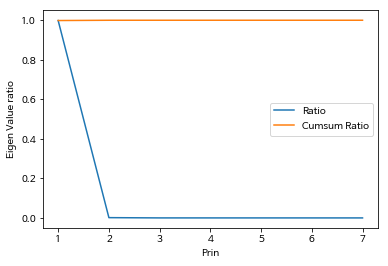

In [121]:
#고유값 비율 그래프 생성
plt.plot(ds_pca["Prin"], ds_pca["EigenValueRatio"], label = "Ratio")
#누적된 고유값 비율 그래프 생성
plt.plot(ds_pca["Prin"], ds_pca["CumsumEigenValueRatio"], label = "Cumsum Ratio")
#그래프 label, legend 설정
plt.ylabel("Eigen Value ratio")
plt.xlabel("Prin")
plt.legend(loc = "best")

### PCA의 경우 Prin1의 요소가 매우 크기 때문에 다른 요소의 비중이 거의 없다고 할 수 있다. 

,Prin1,Prin2,Prin3,Prin4,Prin5,Prin6,Prin7
Prin1,1.0,0.0,-0.0,-0.0,0.0,0.0,-0.0
Prin2,0.0,1.0,0.0,-0.0,0.0,-0.0,-0.0
Prin3,-0.0,0.0,1.0,-0.0,-0.0,0.0,-0.0
Prin4,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,0.0
Prin5,0.0,0.0,-0.0,-0.0,1.0,0.0,0.0
Prin6,0.0,-0.0,0.0,-0.0,0.0,1.0,0.0
Prin7,-0.0,-0.0,-0.0,0.0,0.0,0.0,1.0


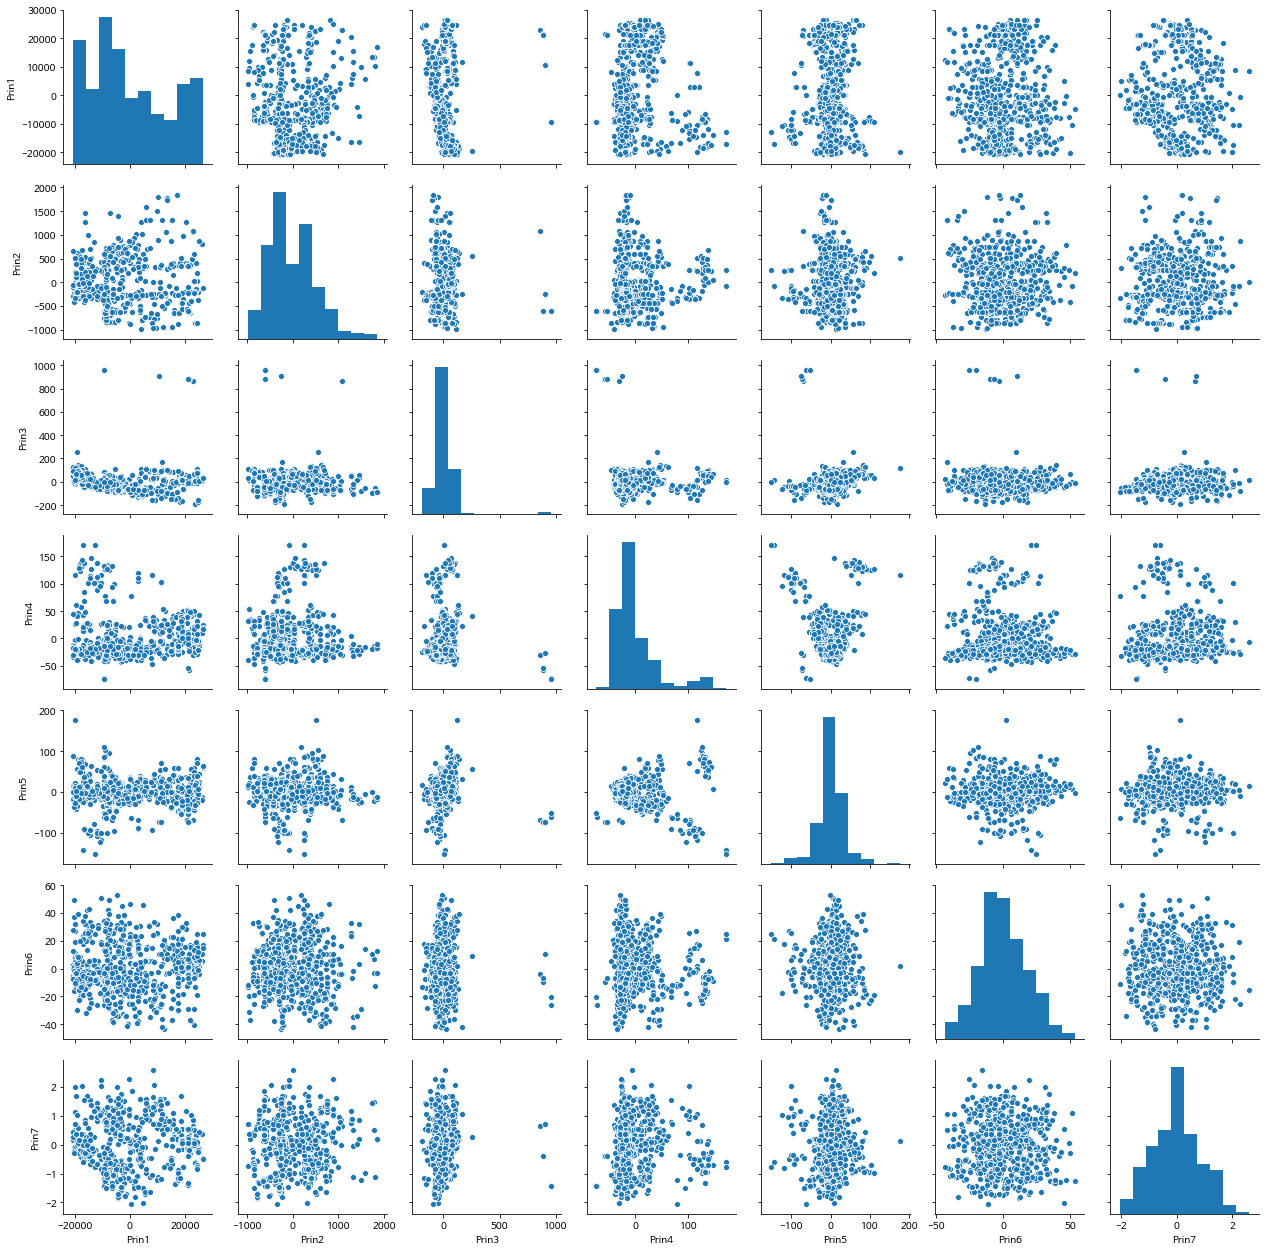

In [122]:
#산점도 행렬
sns.pairplot(ds_x_pca)

#상관계수
ds_x_pca.corr().round(3)

## 종합해보면, 탐색적 분석과 로지스틱 회귀분석을 통하여 다중공선성과 유의한 p-value를 찾아 영향을 주는 컬럼만 찾았다. 그리고 그 결과는  PT_WDTH, PT_LTH, FUR_HZ_TEMP, FUR_HZ_TIME, ROLLING_TEMP_T5, FUR_SZ_TIME, ROLLING_DESCALING 였다. 또한, 이 와중에 ROLLING_TEMP_T5의 설명변수가 모델에 가장 큰 영향을 주는 것을 확인할 수 있었다. (디시전트리의 부모트리 및 Grandient Boosting에서의 설명변수 중요도 분석)
## 추출된 설명변수가 유의하다고 정해졌기 때문에 다른 요소는 배제하고 유의한 데이터를 바탕으로 가장 적합한 모델이 무엇인지 찾기위해 디시전트리, 랜덤포레스트, Grandient Boosting, KNN등 다양한 모델을 만들어 training을 하였고 test데이터와 비교하여 정확도의 차이를 확인하였다. 그결과 Grandient Boosting이 해당 설명변수들에 대하여 가장 우수한 정확도를 나타내는 것을 확인하였다. (실제 80.6%의 정확도를 나타내었음)